# Import libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import json
import os

import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras import Sequential
from keras.layers import Input, Add, Dense, Activation, ZeroPadding1D, Flatten, GlobalAveragePooling1D, Concatenate
from keras.layers import RepeatVector, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout,concatenate, BatchNormalization, Reshape
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.metrics import Precision, Recall, FalseNegatives
from keras.losses import KLDivergence, BinaryCrossentropy, CategoricalCrossentropy

from sklearn.ensemble import IsolationForest
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import KFold, StratifiedKFold

from tqdm.auto import tqdm  # For progress bars

import keras.backend as K
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
K.set_image_data_format('channels_last')

colors_palette = ["#024059", "#0388A6", "#8C031C"] # Starting colors
sns.set_palette(sns.color_palette(colors_palette)) # Set colors for Seaborn
palette = sns.light_palette(colors_palette[0], as_cmap=True) # Palette

# Import data

In [ ]:
X_128 = np.load('Dataset/X_128_2.npy')
y_128 = np.load('Dataset/y_128_2.npy')
maps_idx_128 = np.load('Dataset/maps_idx_128_2.npy')
features_128 = np.load('Dataset/features_128_2.npy')

X_250 = np.load('Dataset/X_250_under_2.npy')
y_250 = np.load('Dataset/y_250_under_2.npy')
maps_idx_250 = np.load('Dataset/maps_idx_250_under_2.npy')
features_250 = np.load('Dataset/features_250_under_2.npy')

In [ ]:
X = np.concatenate([X_128, X_250], axis=0)
y = np.concatenate([y_128, y_250], axis=0)
features = np.concatenate([features_128, features_250], axis=0)
# Fix map to signal
maps_idx_250[:,0] = maps_idx_250[:,0] + np.max(maps_idx_128[:,0]) + 1
maps_idx = np.concatenate([maps_idx_128, maps_idx_250], axis=0)

X.shape, y.shape, maps_idx.shape, features.shape

((117072, 128, 2), (117072, 1), (117072, 2), (117072, 8))

In [ ]:
del X_128, X_250, y_128, y_250, maps_idx_128, maps_idx_250, features_128, features_250

### Remove anomalies

In [ ]:
# Train Isolation Forest model
model = IsolationForest(n_estimators=150, contamination=0.04, bootstrap=True, verbose = False)  # Contamination = expected proportion of anomalies
model.fit(X[:, :, 0])

# Predict the anomaly scores
anomaly_scores = model.decision_function(X[:, :, 0])

# Anomaly scores will be more negative for anomalies
threshold = np.percentile(anomaly_scores, 6)  # Consider bottom 6% as anomalies

# Identify anomalies using the threshold
anomalies_indices = np.where(anomaly_scores < threshold)[0]

# Number of detected anomalies
print(f"Number of anomalies detected: {len(anomalies_indices)}")

Number of anomalies detected: 7023


In [ ]:
# Delete only Normal signals with anomalies
anomalies_N = []
for i in anomalies_indices:
  if y[i]=='N':
    anomalies_N.append(i)

X = np.delete(X, anomalies_N, axis=0)
maps_idx = np.delete(maps_idx, anomalies_N, axis=0)
features = np.delete(features, anomalies_N, axis=0)
y = np.delete(y, anomalies_N, axis=0)

X.shape, y.shape, maps_idx.shape, features.shape

((112869, 128, 2), (112869, 1), (112869, 2), (112869, 8))

# Base model

In [ ]:
class ResNetModel:

    seed = 42

    def __init__(self, input_shape, num_classes, num_features, N, filters, verbose=False, labels=['0', '1']):
        self.model = self.__get_model(input_shape, num_classes, num_features, N, filters)
        self.X_train = self.X_test = self.y_ohe_train = self.y_ohe_test = self.features_train = self.features_test = None
        self.verbose = verbose
        self.labels = labels

    def __get_model(self, input_shape, num_classes, num_features, N, filters):
        # Input
        signal_inputs = Input(shape=input_shape, name = 'SignalInput')
        conv_layer = self.__ResBs_Conv(signal_inputs, filters)


        # Class information branch
        features_input = Input(shape=(num_features,), name = 'FeaturesInput')
        repeat_class = RepeatVector(input_shape[0]//2, name='RepeatLayer')(features_input)
        class_combined = Concatenate(axis=-1, name = 'MergingLayer')([conv_layer, repeat_class])
        conv_layer = self.__ResBs_Conv(class_combined, filters)

        # First Stage Attention
        attention_1 = self.__CBAM_block(conv_layer, filters)

        conv_layer = BatchNormalization()(attention_1)

        # Decoder
        M = int((N - 2)/2)
        for i in range(M):
            filters = filters * 2
            # define N-th ResBs block
            conv_layer = self.__ResBs_Conv(conv_layer, filters)
            conv_layer = self.__ResBs_Identity(conv_layer, filters)

        # Second Stage Attention
        attention_2 = self.__CBAM_block(conv_layer, filters)

        #flatten = Flatten()(attention_2)
        gap = GlobalAveragePooling1D()(attention_2)

        dense = Dense(filters*2, activation='relu', name='dense1')(gap)

        dense = Dense(filters/2, activation='relu', name='dense2')(dense)

        # Classification head
        classification_output = Dense(num_classes, activation='softmax', name='classification_output')(dense)

        model = Model(inputs=[signal_inputs, features_input], outputs=classification_output)

        return model

    def __ResBs_Identity(self, block_input, num_filters):

        # 1. First Convolutional Layer
        conv1 = Conv1D(filters=num_filters, kernel_size=7, padding= 'same')(block_input)
        norm1 = BatchNormalization()(conv1)
        relu1 = Activation('relu')(norm1)
        dropout = Dropout(0.2)(relu1)

        # 2. Second Convolutional Layer
        conv2 = Conv1D(num_filters, kernel_size=7, padding= 'same')(dropout) #per avere concordanza
        norm2 = BatchNormalization()(conv2)

        # 3. Summing Layer (adding a residual connection)
        sum = Add()([block_input, norm2])

        # 4. Activation Layer
        relu2 = Activation('relu')(sum)

        return relu2


    def __ResBs_Conv(self, block_input, num_filters):

        # 0. Filter Block input and BatchNormalization
        block_shortcut = Conv1D(num_filters, kernel_size=7, strides=2,  padding='same')(block_input)
        block_shortcut = BatchNormalization()(block_shortcut)

        # 1. First Convolutional Layer
        conv1 = Conv1D(filters=num_filters, kernel_size=7, strides=2, padding='same')(block_input)
        norm1 = BatchNormalization()(conv1)
        relu1 = Activation('relu')(norm1)
        dropout = Dropout(0.2)(relu1)

        # 2. Second Convolutional Layer
        conv2 = Conv1D(num_filters, kernel_size=7, padding='same')(dropout) # per avere concordanza
        norm2 = BatchNormalization()(conv2)

        # 3. Summing Layer (adding a residual connection)
        sum = Add()([block_shortcut, norm2])

        # 4. Activation Layer
        relu2 = Activation('relu')(sum)

        return relu2


    def __CBAM_block(self, in_block, ch, ratio=16):
        # 1. Channel attention block
        avg_pool = tf.reduce_mean(in_block, axis=1, keepdims=True)
        max_pool = tf.reduce_max(in_block, axis=1, keepdims=True)

        dense1 = Conv1D(filters=ch // ratio, kernel_size=1, activation='relu')
        avg_reduced = dense1(avg_pool)
        max_reduced = dense1(max_pool)

        dense2 = Conv1D(filters=ch, kernel_size=1, activation='sigmoid')
        avg_attention = dense2(avg_reduced)
        max_attention = dense2(max_reduced)

        x = tf.add(avg_attention, max_attention)
        x = tf.nn.sigmoid(x)
        x = tf.multiply(in_block, x)

        # 2. Spatial attention block
        y_mean = tf.reduce_mean(x, axis=-1, keepdims=True)
        y_max = tf.reduce_max(x, axis=-1, keepdims=True)

        y = tf.concat([y_mean, y_max], axis=-1)
        y = Conv1D(filters=1, kernel_size=5, padding='same', activation='sigmoid')(y)
        y = tf.multiply(x, y)

        return y

    def __compute_class_weights(self):
        y_integers = np.argmax(self.y_ohe_train, axis=1)
        class_weights = compute_class_weight(class_weight='balanced', y=y_integers, classes=np.unique(y_integers))
        d_class_weights = dict(enumerate(class_weights))
        return d_class_weights

    def get_summary_model(self):
        self.model.summary()

    def compile_train_model(self, metrics, loss, callbacks, lr, batch_size, epochs, validation_split, use_sample_weight=False):

        if self.X_train is None:
            raise ValueError("Data has not been preprocessed!")

        self.model.compile(
            optimizer = keras.optimizers.Adam(lr),
            loss = loss,
            metrics = metrics
        )

        self.model.fit(
            x = [self.X_train, self.features_train],
            y = self.y_ohe_train,
            batch_size = batch_size,
            epochs = epochs,
            validation_split = validation_split,
            callbacks = callbacks,
            class_weight=self.__compute_class_weights() if use_sample_weight else None
        )

    def test_model(self):

        if self.X_test is None:
            raise ValueError("There is no data to test!")

        predicted_probabilities = self.model.predict([self.X_test, self.features_test])
        predicted_labels = np.argmax(predicted_probabilities, axis=-1)
        true_labels = np.argmax(self.y_ohe_test, axis=-1)

        confusion_mat = confusion_matrix(true_labels, predicted_labels)
        precision = precision_score(true_labels, predicted_labels)
        recall = recall_score(true_labels, predicted_labels)
        f1 = f1_score(true_labels, predicted_labels)

        if self.verbose:
            colors_palette = ["#024059", "#0388A6", "#8C031C"]
            # Build Seaborn palette with cmap=True
            palette = sns.light_palette(colors_palette[0], as_cmap=True)
            plt.figure(figsize=(6, 5))
            sns.heatmap(confusion_mat, xticklabels=self.labels, yticklabels=self.labels, cmap = palette, annot=True, fmt='g')
            plt.xlabel('Predicted labels')
            plt.ylabel('True labels')
            plt.title('Confusion Matrix')
            plt.show()
            print('Precision {:.5f} Recall {:.5f} F1 {:.5f}'.format(precision, recall, f1))

        return confusion_mat, precision, recall, f1

    def get_predictions_model(self, X, features):
        predicted_probabilities = self.model.predict([X, features])
        predicted_labels = np.argmax(predicted_probabilities, axis=-1)
        return predicted_labels

    def save_model(self, name, path="./Models"):
        final_path = os.path.join(path, name+'.keras')
        if self.verbose:
            print("Saving model at", final_path)
        self.model.save(final_path)

    def preprocess_data(self, X, features, y):
        pass


# Helper functions

In [ ]:
def get_metrics():
    precision =  Precision(name='precision')
    recall =  Recall(name='recall')
    fn = FalseNegatives(name='fn')
    return [precision, recall, fn]

def get_callbacks(patience_es=4, patience_lr=3, factor_lr=.1, monitor='val_recall'):
    return [
        EarlyStopping(
            mode = 'max',
            monitor=monitor,
            patience=patience_es,
            restore_best_weights=True
        ),
        ReduceLROnPlateau(
            mode = 'max',
            monitor=monitor,
            factor=factor_lr,
            patience=patience_lr,
            verbose=1
        )
    ]

def get_score_model(predicted_labels, true_labels):
    confusion_mat = confusion_matrix(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average=None)
    recall = recall_score(true_labels, predicted_labels, average=None)
    f1 = f1_score(true_labels, predicted_labels, average=None)
    return confusion_mat, precision, recall, f1


# Model 1: Normal vs Abnormal

In [ ]:
class NormalAbnormalModel(ResNetModel):
    def __init__(self, input_shape, num_classes, num_features, N, filters, verbose, labels):
        super().__init__(input_shape, num_classes, num_features, N, filters, verbose, labels)

    def preprocess_data(self, X, features, y, test_size = None):

        map_nor_abn = {'N': [1, 0], 'S': [0, 1], 'V': [0, 1]}
        y_ohe = np.array([map_nor_abn[label[0]] for label in y], dtype=np.float32)

        if test_size is None:
            self.X_train = X
            self.y_ohe_train = y_ohe
            self.features_train = features
        else:
            self.X_train, self.X_test, self.y_ohe_train, self.y_ohe_test, self.features_train, self.features_test = train_test_split(
                X, y_ohe, features,
                test_size=test_size,
                stratify=y,
                random_state=self.seed,
                shuffle=True
            )

        if self.verbose:
            print('X_train.shape {} y_ohe_train.shape {} features_test.shape {}'.format(self.X_train.shape,  self.y_ohe_train.shape, self.features_train.shape))
            if test_size is not None:
                print('X_test.shape {} y_ohe_test.shape {} features_test.shape {}'.format(self.X_test.shape, self.y_ohe_test.shape, self.features_test.shape))

X_train.shape (101582, 128, 2) y_ohe_train.shape (101582, 2) features_test.shape (101582, 8)
X_test.shape (11287, 128, 2) y_ohe_test.shape (11287, 2) features_test.shape (11287, 8)
Epoch 1/20
358/358 [==============================] - 61s 100ms/step - loss: 0.0802 - precision: 0.9719 - recall: 0.9719 - fn: 2569.0000 - val_loss: 0.1106 - val_precision: 0.9636 - val_recall: 0.9636 - val_fn: 370.0000 - lr: 0.0010
Epoch 2/20
358/358 [==============================] - 34s 95ms/step - loss: 0.0715 - precision: 0.9748 - recall: 0.9748 - fn: 2300.0000 - val_loss: 0.0714 - val_precision: 0.9768 - val_recall: 0.9768 - val_fn: 236.0000 - lr: 0.0010
Epoch 3/20
358/358 [==============================] - 34s 95ms/step - loss: 0.0685 - precision: 0.9764 - recall: 0.9764 - fn: 2160.0000 - val_loss: 0.0783 - val_precision: 0.9721 - val_recall: 0.9721 - val_fn: 283.0000 - lr: 0.0010
Epoch 4/20
358/358 [==============================] - 34s 95ms/step - loss: 0.0650 - precision: 0.9775 - recall: 0.9775 - 

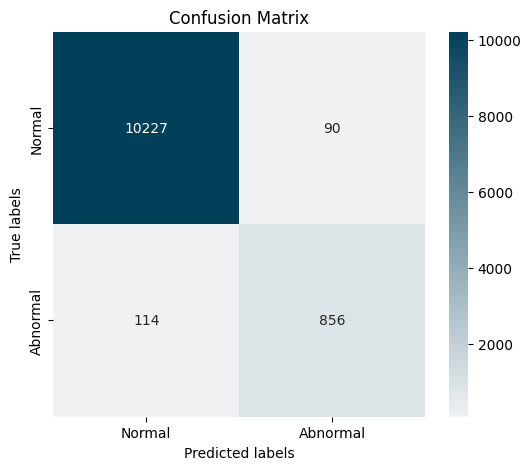

Precision 0.90486 Recall 0.88247 F1 0.89353


(array([[10227,    90],
        [  114,   856]]),
 0.904862579281184,
 0.8824742268041237,
 0.8935281837160751)

In [ ]:
nor_abn_model = NormalAbnormalModel(
        input_shape=X.shape[1:],
        num_classes=2,
        num_features=8,
        N=6,
        filters=128,
        verbose=True,
        labels=["Normal", "Abnormal"]
    )
nor_abn_model.preprocess_data(X, features, y, test_size=.1)
nor_abn_model.compile_train_model(
    metrics = get_metrics(),
    loss = KLDivergence(reduction="sum_over_batch_size", name="kl_divergence"),
    callbacks = get_callbacks(),
    lr=1e-3,
    batch_size=256,
    epochs=20,
    validation_split=.1
)
nor_abn_model.test_model()

### Cross Validation

In [ ]:
metrics = {'folds':[]}
i = 1

kf = KFold(n_splits=10, shuffle=True, random_state=42)

for train_ids, test_ids in kf.split(np.arange(len(X))):

    print("Fold", i)
    i = i+1

    X_train = X[train_ids]
    X_test = X[test_ids]
    features_train = features[train_ids]
    features_test = features[test_ids]
    y_train = y[train_ids]
    y_test = y[test_ids]

    train_uniques, train_counts = np.unique(y_train, return_counts=True)
    test_uniques, test_counts = np.unique(y_test, return_counts=True)
    fold_metrics = {'train_unique':train_uniques.tolist(), 'train_dist':train_counts.tolist(), 'test_unique':test_uniques.tolist(), 'test_dist':test_counts.tolist()}

    nor_abn_model = NormalAbnormalModel(
        input_shape=X_train.shape[1:],
        num_classes=2,
        num_features=8,
        N=6,
        filters=128,
        verbose=False,
        labels=["Normal", "Abnormal"]
    )
    nor_abn_model.preprocess_data(X_train, features_train, y_train)
    nor_abn_model.compile_train_model(
        metrics = get_metrics(),
        loss = KLDivergence(reduction="sum_over_batch_size", name="kl_divergence"),
        callbacks = get_callbacks(),
        lr=1e-3,
        batch_size=256,
        epochs=20,
        validation_split=.1
    )

    # Evaluate models on unseen data
    pred_nor_abn = nor_abn_model.get_predictions_model(X_test, features_test)
    map_labels = {'N': 0, 'V': 1, 'S': 1}
    y_real = np.array([map_labels[label[0]] for label in y_test], dtype=np.float32)

    confusion_mat, precision, recall, f1 = get_score_model(pred_nor_abn, y_real)
    fold_metrics['conf_matrix'] = confusion_mat.tolist()
    fold_metrics['precision'] = precision.tolist()
    fold_metrics['recall'] = recall.tolist()
    fold_metrics['f1'] = f1.tolist()
    metrics['folds'].append(fold_metrics)


with open('./Metrics/metrics_cv_nor_abn_model.json', 'w') as jsonfile:
    json.dump(metrics, jsonfile)

Fold 1
Epoch 1/20
358/358 [==============================] - 43s 52ms/step - loss: 0.0872 - precision: 0.9671 - recall: 0.9671 - fn: 3012.0000 - val_loss: 0.0111 - val_precision: 0.9997 - val_recall: 0.9997 - val_fn: 3.0000 - lr: 0.0010
Epoch 2/20
358/358 [==============================] - 16s 45ms/step - loss: 0.0743 - precision: 0.9738 - recall: 0.9738 - fn: 2401.0000 - val_loss: 0.0054 - val_precision: 0.9994 - val_recall: 0.9994 - val_fn: 6.0000 - lr: 0.0010
Epoch 3/20
358/358 [==============================] - 18s 49ms/step - loss: 0.0708 - precision: 0.9750 - recall: 0.9750 - fn: 2288.0000 - val_loss: 0.0070 - val_precision: 0.9963 - val_recall: 0.9963 - val_fn: 38.0000 - lr: 0.0010
Epoch 4/20
357/358 [============================>.] - ETA: 0s - loss: 0.0685 - precision: 0.9759 - recall: 0.9759 - fn: 2201.0000
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
358/358 [==============================] - 17s 46ms/step - loss: 0.0685 - precision: 0.9759 - r

# Model 2: Ventricular vs Sopraventricular

In [ ]:
class VentricularSopraventricularModel(ResNetModel):
    def __init__(self, input_shape, num_classes, num_features, N, filters, verbose, labels):
        super().__init__(input_shape, num_classes, num_features, N, filters, verbose, labels)

    def preprocess_data(self, X, features, y, test_size = None):

        # Remove normal beats
        normal_indices = np.where(y == 'N')[0]
        X = np.delete(X, normal_indices, axis=0)
        features = np.delete(features, normal_indices, axis=0)
        y = np.delete(y, normal_indices, axis=0)

        map_v_s = {'V': [1, 0], 'S': [0, 1]}
        y_ohe = np.array([map_v_s[label[0]] for label in y], dtype=np.float32)

        if test_size is None:
            self.X_train = X
            self.y_ohe_train = y_ohe
            self.features_train = features
        else:
            self.X_train, self.X_test, self.y_ohe_train, self.y_ohe_test, self.features_train, self.features_test = train_test_split(
                X, y_ohe, features,
                test_size=test_size,
                stratify=y,
                random_state=self.seed,
                shuffle=True
            )

        if self.verbose:
            print('X_train.shape {} y_ohe_train.shape {} features_test.shape {}'.format(self.X_train.shape,  self.y_ohe_train.shape, self.features_train.shape))
            if test_size is not None:
                print('X_test.shape {} y_ohe_test.shape {} features_test.shape {}'.format(self.X_test.shape, self.y_ohe_test.shape, self.features_test.shape))

X_train.shape (8727, 128, 2) y_ohe_train.shape (8727, 2) features_test.shape (8727, 8)
X_test.shape (970, 128, 2) y_ohe_test.shape (970, 2) features_test.shape (970, 8)
Epoch 1/70
62/62 [==============================] - 14s 38ms/step - loss: 0.5655 - precision: 0.6808 - recall: 0.6808 - fn: 2507.0000 - val_loss: 1.3112 - val_precision: 0.4353 - val_recall: 0.4353 - val_fn: 493.0000 - lr: 0.0010
Epoch 2/70
62/62 [==============================] - 2s 27ms/step - loss: 0.5254 - precision: 0.7170 - recall: 0.7170 - fn: 2223.0000 - val_loss: 0.9360 - val_precision: 0.4387 - val_recall: 0.4387 - val_fn: 490.0000 - lr: 0.0010
Epoch 3/70
62/62 [==============================] - 2s 27ms/step - loss: 0.5037 - precision: 0.7306 - recall: 0.7306 - fn: 2116.0000 - val_loss: 0.7683 - val_precision: 0.6334 - val_recall: 0.6334 - val_fn: 320.0000 - lr: 0.0010
Epoch 4/70
62/62 [==============================] - 2s 35ms/step - loss: 0.4984 - precision: 0.7367 - recall: 0.7367 - fn: 2068.0000 - val_loss

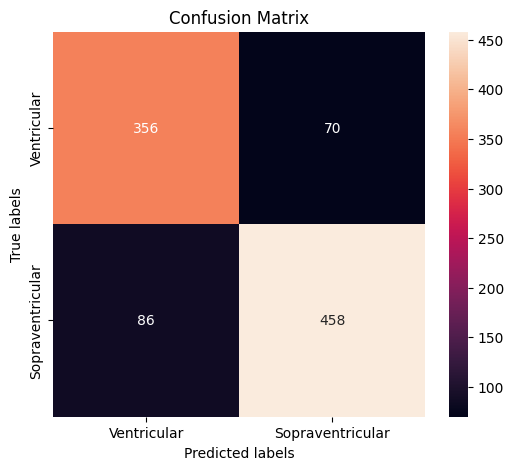

Precision 0.86742 Recall 0.84191 F1 0.85448


(array([[356,  70],
        [ 86, 458]]),
 0.8674242424242424,
 0.8419117647058824,
 0.8544776119402985)

In [ ]:
ven_sop_model = VentricularSopraventricularModel(
    input_shape=X.shape[1:],
    num_classes=2,
    num_features=8,
    N=4,
    filters=128,
    verbose=True,
    labels=["Ventricular", "Sopraventricular"]
)
ven_sop_model.preprocess_data(X, features, y, test_size=.1)
ven_sop_model.compile_train_model(
    metrics = get_metrics(),
    loss = BinaryCrossentropy(),
    callbacks = get_callbacks(patience_es=30, patience_lr=25),
    lr=1e-3,
    batch_size=128,
    epochs=70,
    validation_split=.1
)
ven_sop_model.test_model()

### Cross Validation

In [ ]:
metrics = {'folds':[]}
i = 1

#kf = KFold(n_splits=10, shuffle=True, random_state=42)

kf = StratifiedKFold(n_splits=10, shuffle=True)
normal_indices = np.where(y == 'N')[0]
X_v_s = np.delete(X, normal_indices, axis=0)
features_v_s = np.delete(features, normal_indices, axis=0)
y_v_s = np.delete(y, normal_indices, axis=0)

for train_ids, test_ids in kf.split(X_v_s, y_v_s):

    print("Fold", i)
    i = i+1

    X_train = X_v_s[train_ids]
    X_test = X_v_s[test_ids]
    features_train = features_v_s[train_ids]
    features_test = features_v_s[test_ids]
    y_train = y_v_s[train_ids]
    y_test = y_v_s[test_ids]

    train_uniques, train_counts = np.unique(y_train, return_counts=True)
    test_uniques, test_counts = np.unique(y_test, return_counts=True)
    fold_metrics = {'train_unique':train_uniques.tolist(), 'train_dist':train_counts.tolist(), 'test_unique':test_uniques.tolist(), 'test_dist':test_counts.tolist()}

    ven_sop_model = VentricularSopraventricularModel(
        input_shape=X.shape[1:],
        num_classes=2,
        num_features=8,
        N=4,
        filters=128,
        verbose=True,
        labels=["Ventricular", "Sopraventricular"]
    )
    ven_sop_model.preprocess_data(X_train, features_train, y_train)
    ven_sop_model.compile_train_model(
        metrics = get_metrics(),
        loss = BinaryCrossentropy(),
        callbacks = get_callbacks(patience_es=30, patience_lr=25),
        lr=1e-3,
        batch_size=128,
        epochs=70,
        validation_split=.1
    )

    # Evaluate models on unseen data
    pred_ven_sop = ven_sop_model.get_predictions_model(X_test, features_test)
    map_labels = {'V': 0, 'S': 1}
    y_real = np.array([map_labels[label[0]] for label in y_test], dtype=np.float32)

    confusion_mat, precision, recall, f1 = get_score_model(pred_ven_sop, y_real)
    print(confusion_mat, precision, recall, f1)
    fold_metrics['conf_matrix'] = confusion_mat.tolist()
    fold_metrics['precision'] = precision.tolist()
    fold_metrics['recall'] = recall.tolist()
    fold_metrics['f1'] = f1.tolist()
    metrics['folds'].append(fold_metrics)

    del ven_sop_model


with open('./Metrics/metrics_cv_ven_sop_model.json', 'w') as jsonfile:
    json.dump(metrics, jsonfile)

# Complete Model

In [ ]:
class CompleteModel(ResNetModel):
    def __init__(self, input_shape, num_classes, num_features, N, filters, verbose, labels):
        super().__init__(input_shape, num_classes, num_features, N, filters, verbose, labels)

    def preprocess_data(self, X, features, y, test_size = None):

        map_nor_abn = {'N': [1, 0, 0], 'V': [0, 1, 0], 'S': [0, 0, 1]}
        y_ohe = np.array([map_nor_abn[label[0]] for label in y], dtype=np.float32)

        if test_size is None:
            self.X_train = X
            self.y_ohe_train = y_ohe
            self.features_train = features
        else:
            self.X_train, self.X_test, self.y_ohe_train, self.y_ohe_test, self.features_train, self.features_test = train_test_split(
                X, y_ohe, features,
                test_size=test_size,
                stratify=y,
                random_state=self.seed,
                shuffle=True
            )

        if self.verbose:
            print('X_train.shape {} y_ohe_train.shape {} features_test.shape {}'.format(self.X_train.shape,  self.y_ohe_train.shape, self.features_train.shape))
            uniques, counts = np.unique(self.y_ohe_train, return_counts=True, axis=0)
            print('Distribution training set:', uniques, counts)
            if test_size is not None:
                print('X_test.shape {} y_ohe_test.shape {} features_test.shape {}'.format(self.X_test.shape, self.y_ohe_test.shape, self.features_test.shape))

### Cross validation single model

In [ ]:
metrics = {'folds':[]}
i=1
kf = KFold(n_splits=10, shuffle=True, random_state=42)
unique_signal_ids = np.unique(maps_idx[:,0])

for train_signal_ids, test_signal_ids in kf.split(unique_signal_ids):

    print("Fold", i)
    i=i+1

    fold_metrics = {'train_signals':train_signal_ids.tolist(), 'test_signal':test_signal_ids.tolist()}

    train_mask = np.isin(maps_idx[:,0], train_signal_ids)
    test_mask = np.isin(maps_idx[:,0], test_signal_ids)

    X_train = X[train_mask, :]
    X_test = X[test_mask, :]
    features_train = features[train_mask, :]
    features_test = features[test_mask, :]
    y_train = y[train_mask,:]
    y_test = y[test_mask,:]

    train_uniques, train_counts = np.unique(y_train, return_counts=True)
    test_uniques, test_counts = np.unique(y_test, return_counts=True)
    print("Train:", train_uniques, train_counts, "Test:", test_uniques, test_counts)
    fold_metrics['train_unique'] = train_uniques.tolist()
    fold_metrics['test_unique'] = test_uniques.tolist()
    fold_metrics['train_dist'] = train_counts.tolist()
    fold_metrics['test_dist'] = test_counts.tolist()

    # Train 1st model
    c_model = CompleteModel(
        input_shape=X_train.shape[1:],
        num_classes=3,
        num_features=8,
        N=6,
        filters=128,
        verbose=True,
        labels=["N", "V", "S"]
    )
    c_model.preprocess_data(X_train, features_train, y_train)
    c_model.compile_train_model(
        metrics = get_metrics(),
        loss = CategoricalCrossentropy(),
        callbacks = get_callbacks(patience_es=10, patience_lr=7),
        lr=1e-4,
        batch_size=256,
        epochs=30,
        validation_split=0.1,
        use_sample_weight=True
    )

    # Evaluate models on unseen data
    pred = c_model.get_predictions_model(X_test, features_test)

    map_labels = {'N': 0, 'V': 1, 'S': 2}
    y_real = np.array([map_labels[label[0]] for label in y_test], dtype=np.float32)

    confusion_mat, precision, recall, f1 = get_score_model(pred, y_real)
    print(confusion_mat, precision, recall, f1)
    fold_metrics['conf_matrix'] = confusion_mat.tolist()
    fold_metrics['precision'] = precision.tolist()
    fold_metrics['recall'] = recall.tolist()
    fold_metrics['f1'] = f1.tolist()
    metrics['folds'].append(fold_metrics)

with open('./Metrics/metrics_cv_complete.json', 'w') as jsonfile:
    json.dump(metrics, jsonfile)

### Bagging

In [ ]:
def create_bootstrap_samples(X, features, y, indexes_N, indexes_V, indexes_S):
    # Generate the bootstraps per class
    bootstrap_indices_N_idx = np.random.randint(low=0, high=len(indexes_N), size=int(0.25 * len(indexes_N)))
    bootstrap_indices_N = indexes_N[bootstrap_indices_N_idx]
    bootstrap_indices_V_idx = np.random.randint(low=0, high=len(indexes_V), size=len(indexes_V))
    bootstrap_indices_V = indexes_V[bootstrap_indices_V_idx]
    bootstrap_indices_S_idx = np.random.randint(low=0, high=len(indexes_S), size=len(indexes_S))
    bootstrap_indices_S = indexes_S[bootstrap_indices_S_idx]

    # Joint the indexes
    bootstrap_indices = np.concatenate([bootstrap_indices_N, bootstrap_indices_V, bootstrap_indices_S], axis=0)
    np.random.shuffle(bootstrap_indices)

    # Create the oob samples
    oob_N_complete = np.delete(indexes_N, bootstrap_indices_N_idx, axis=0)
    oob_N = np.random.randint(low=0, high=len(oob_N_complete), size=int(0.25 * len(oob_N_complete)))
    oob_N = oob_N_complete[oob_N]

    oob_V = np.delete(indexes_V, bootstrap_indices_V_idx, axis=0)
    oob_S = np.delete(indexes_S, bootstrap_indices_S_idx, axis=0)

    oob_indices = np.concatenate([oob_N, oob_V, oob_S], axis=0)
    np.random.shuffle(oob_indices)

    return X[bootstrap_indices], features[bootstrap_indices], y[bootstrap_indices], X[oob_indices], features[oob_indices], y[oob_indices]

In [ ]:
bagging_models = []

X_train, X_test, y_train, y_test, features_train, features_test = train_test_split(
    X, y, features,
    test_size=0.1,
    stratify=y,
    shuffle=True
)

indexes_N = np.where(y_train =='N')[0]
indexes_V = np.where(y_train =='V')[0]
indexes_S = np.where(y_train =='S')[0]

n_bootstraps = 10

for i in range(n_bootstraps):
    print(f'Building bootstrap {i}')
    X_boot, features_boot, y_boot, X_oob, features_oob, y_oob = create_bootstrap_samples(X, features, y, indexes_N, indexes_V, indexes_S)

    c_model_bagging = CompleteModel(
        input_shape=X_train.shape[1:],
        num_classes=3,
        num_features=8,
        N=4,
        filters=128,
        verbose=True,
        labels=["N", "V", "S"]
    )
    c_model_bagging.preprocess_data(X_boot, features_boot, y_boot)
    c_model_bagging.compile_train_model(
        metrics = get_metrics(),
        loss = CategoricalCrossentropy(),
        callbacks = get_callbacks(patience_es=5, patience_lr=5),
        lr=1e-4,
        batch_size=256,
        epochs=15,
        validation_split=0.1,
        use_sample_weight=False
    )

    pred = c_model_bagging.get_predictions_model(X_oob, features_oob)

    map_labels = {'N': 0, 'V': 1, 'S': 2}
    y_real = np.array([map_labels[label[0]] for label in y_oob], dtype=np.float32)

    confusion_mat, precision, recall, f1 = get_score_model(pred, y_real)
    print(confusion_mat, precision, recall, f1)

    bagging_models.append({'Idx': i, 'Model': c_model_bagging, 'Precision': precision, 'Recall': recall, 'F1': f1})

    del X_boot, features_boot, y_boot, c_model_bagging


### Cross-Validation Bagging

In [ ]:
def majority_vote(predictions):
    predictions_array = np.array(predictions)
    final_predictions = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=predictions_array)

    return final_predictions

In [ ]:
def create_bootstrap_samples_CV(X_t, features_t, y_t, indexes_N, indexes_V, indexes_S):
    # Generate the bootstraps per class
    bootstrap_indices_N_idx = np.random.randint(low=0, high=len(indexes_N), size=int(0.30 * len(indexes_N)))
    bootstrap_indices_N = indexes_N[bootstrap_indices_N_idx]
    bootstrap_indices_V_idx = np.random.randint(low=0, high=len(indexes_V), size=len(indexes_V))
    bootstrap_indices_V = indexes_V[bootstrap_indices_V_idx]
    bootstrap_indices_S_idx = np.random.randint(low=0, high=len(indexes_S), size=len(indexes_S))
    bootstrap_indices_S = indexes_S[bootstrap_indices_S_idx]

    # Joint the indexes
    bootstrap_indices = np.concatenate([bootstrap_indices_N, bootstrap_indices_V, bootstrap_indices_S], axis=0)
    np.random.shuffle(bootstrap_indices)

    return X_t[bootstrap_indices], features_t[bootstrap_indices], y_t[bootstrap_indices]

In [ ]:
metrics = {'folds':[]}
fold=1
kf = KFold(n_splits=10, shuffle=True, random_state=42)
unique_signal_ids = np.unique(maps_idx[:,0])

for train_signal_ids, test_signal_ids in kf.split(unique_signal_ids):

    print("Fold", fold)
    fold=fold+1

    fold_metrics = {'train_signals':train_signal_ids.tolist(), 'test_signal':test_signal_ids.tolist()}

    train_mask = np.isin(maps_idx[:,0], train_signal_ids)
    test_mask = np.isin(maps_idx[:,0], test_signal_ids)

    X_train = X[train_mask, :]
    X_test = X[test_mask, :]
    features_train = features[train_mask, :]
    features_test = features[test_mask, :]
    y_train = y[train_mask,:]
    y_test = y[test_mask,:]

    train_uniques, train_counts = np.unique(y_train, return_counts=True)
    test_uniques, test_counts = np.unique(y_test, return_counts=True)
    print("Train:", train_uniques, train_counts, "Test:", test_uniques, test_counts)
    fold_metrics['train_unique'] = train_uniques.tolist()
    fold_metrics['test_unique'] = test_uniques.tolist()
    fold_metrics['train_dist'] = train_counts.tolist()
    fold_metrics['test_dist'] = test_counts.tolist()

    bagging_models_cv = []
    indexes_N = np.where(y_train =='N')[0]
    indexes_V = np.where(y_train =='V')[0]
    indexes_S = np.where(y_train =='S')[0]

    n_bootstraps = 10

    for i in range(n_bootstraps):
        print(f'Building bootstrap model {i+1}')
        X_boot, features_boot, y_boot = create_bootstrap_samples_CV(X_train, features_train, y_train, indexes_N, indexes_V, indexes_S)

        c_model_bagging = CompleteModel(
            input_shape=X_train.shape[1:],
            num_classes=3,
            num_features=8,
            N=4,
            filters=128,
            verbose=True,
            labels=["N", "V", "S"]
        )
        c_model_bagging.preprocess_data(X_boot, features_boot, y_boot)
        c_model_bagging.compile_train_model(
            metrics = get_metrics(),
            loss = CategoricalCrossentropy(),
            callbacks = get_callbacks(patience_es=5, patience_lr=3),
            lr=1e-4,
            batch_size=256,
            epochs=10,
            validation_split=0.1,
            use_sample_weight=False
        )

        bagging_models_cv.append({'Idx': i, 'Model': c_model_bagging})

        del X_boot, features_boot, y_boot, c_model_bagging

    # Prediction with test set
    predictions = []
    map_labels = {'N': 0, 'V': 1, 'S': 2}
    y_real = np.array([map_labels[label[0]] for label in y_test], dtype=np.float32)
    for model in bagging_models_cv:
        predictions.append(np.array(model['Model'].get_predictions_model(X_test, features_test)))

    del bagging_models_cv

    final_predictions = majority_vote(predictions)

    confusion_mat, precision, recall, f1 = get_score_model(final_predictions, y_real)
    print(confusion_mat, precision, recall, f1)
    fold_metrics['conf_matrix'] = confusion_mat.tolist()
    fold_metrics['precision'] = precision.tolist()
    fold_metrics['recall'] = recall.tolist()
    fold_metrics['f1'] = f1.tolist()
    metrics['folds'].append(fold_metrics)

    del predictions, final_predictions, indexes_N, indexes_V, indexes_S

with open('./Metrics/metrics_cv_bagging.json', 'w') as jsonfile:
    json.dump(metrics, jsonfile)


# Final training

### Model Normal vs Abnormal

In [ ]:
final_nor_abn_model = NormalAbnormalModel(
    input_shape=X.shape[1:],
    num_classes=2,
    num_features=8,
    N=6,
    filters=128,
    verbose=True,
    labels=["Normal", "Abnormal"]
)
final_nor_abn_model.preprocess_data(X, features, y)
final_nor_abn_model.compile_train_model(
    metrics = get_metrics(),
    loss = KLDivergence(reduction="sum_over_batch_size", name="kl_divergence"),
    callbacks = get_callbacks(),
    lr=1e-3,
    batch_size=256,
    epochs=25,
    validation_split=.1
)
final_nor_abn_model.save_model("normal_abnormal")

X_train.shape (112848, 128, 2) y_ohe_train.shape (112848, 2) features_test.shape (112848, 8)
Epoch 1/25
397/397 [==============================] - 58s 103ms/step - loss: 0.0936 - precision: 0.9642 - recall: 0.9642 - fn: 3641.0000 - val_loss: 0.0098 - val_precision: 0.9962 - val_recall: 0.9962 - val_fn: 43.0000 - lr: 0.0010
Epoch 2/25
397/397 [==============================] - 37s 93ms/step - loss: 0.0785 - precision: 0.9717 - recall: 0.9717 - fn: 2872.0000 - val_loss: 0.0065 - val_precision: 0.9993 - val_recall: 0.9993 - val_fn: 8.0000 - lr: 0.0010
Epoch 3/25
397/397 [==============================] - 38s 96ms/step - loss: 0.0732 - precision: 0.9742 - recall: 0.9742 - fn: 2624.0000 - val_loss: 0.0060 - val_precision: 0.9996 - val_recall: 0.9996 - val_fn: 5.0000 - lr: 0.0010
Epoch 4/25
397/397 [==============================] - 39s 98ms/step - loss: 0.0703 - precision: 0.9752 - recall: 0.9752 - fn: 2515.0000 - val_loss: 0.0151 - val_precision: 0.9914 - val_recall: 0.9914 - val_fn: 97.00

### Bagging classifier

In [ ]:
indexes_N = np.where(y =='N')[0]
indexes_V = np.where(y =='V')[0]
indexes_S = np.where(y =='S')[0]

n_bootstraps = 10

for i in range(n_bootstraps):
    print(f'Building bootstrap {i}')

    X_boot, features_boot, y_boot = create_bootstrap_samples_CV(X, features, y, indexes_N, indexes_V, indexes_S)

    c_model_bagging = CompleteModel(
        input_shape=X.shape[1:],
        num_classes=3,
        num_features=8,
        N=4,
        filters=128,
        verbose=True,
        labels=["N", "V", "S"]
    )
    c_model_bagging.preprocess_data(X_boot, features_boot, y_boot)
    c_model_bagging.compile_train_model(
        metrics = get_metrics(),
        loss = CategoricalCrossentropy(),
        callbacks = get_callbacks(patience_es=5, patience_lr=5),
        lr=1e-4,
        batch_size=256,
        epochs=20,
        validation_split=0.1
    )

    c_model_bagging.save_model(f'bagging_model_{i}', path="./Models/Bagging")

    del X_boot, features_boot, y_boot, c_model_bagging


Building bootstrap 0
X_train.shape (40653, 128, 2) y_ohe_train.shape (40653, 3) features_test.shape (40653, 8)
Distribution training set: [[0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]] [ 5281  4416 30956]
Epoch 1/20
143/143 [==============================] - 45s 51ms/step - loss: 0.2799 - precision: 0.9055 - recall: 0.8566 - fn: 5245.0000 - val_loss: 0.5183 - val_precision: 0.9092 - val_recall: 0.7634 - val_fn: 962.0000 - lr: 1.0000e-04
Epoch 2/20
143/143 [==============================] - 4s 30ms/step - loss: 0.2401 - precision: 0.9114 - recall: 0.8824 - fn: 4303.0000 - val_loss: 0.3809 - val_precision: 0.8878 - val_recall: 0.8060 - val_fn: 789.0000 - lr: 1.0000e-04
Epoch 3/20
143/143 [==============================] - 5s 34ms/step - loss: 0.2307 - precision: 0.9153 - recall: 0.8903 - fn: 4014.0000 - val_loss: 0.3083 - val_precision: 0.9016 - val_recall: 0.8180 - val_fn: 740.0000 - lr: 1.0000e-04
Epoch 4/20
143/143 [==============================] - 4s 29ms/step - loss: 0.2198 - precision: 0.92